# Импорт библиотек

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import warnings

# Вспомогательный код

In [20]:
warnings.filterwarnings("ignore", category=FutureWarning) # чтобы убрать предупреждение при выводе экспоненциального сглаживания

sns.set(style="whitegrid")  # установка стиля seaborn для графиков

# Чтение и предобработка данных

In [21]:
ticker = "MSFT"

data = yf.download(ticker, start="2022-01-01", end="2023-12-31", auto_adjust=True, progress=False)
ts = data['Close']
ts.name = "Цена закрытия"

print(f"Анализ временного ряда для {ticker} (2022-2023)")
print("Первые 5 значений ряда:")
print(ts.head())
print("\nПоследние 5 значений ряда:")
print(ts.tail())

Анализ временного ряда для MSFT (2022-2023)
Первые 5 значений ряда:
Ticker            MSFT
Date                  
2022-01-03  325.038055
2022-01-04  319.464630
2022-01-05  307.201050
2022-01-06  304.773529
2022-01-07  304.928894

Последние 5 значений ряда:
Ticker            MSFT
Date                  
2023-12-22  370.375732
2023-12-26  370.454865
2023-12-27  369.871521
2023-12-28  371.067871
2023-12-29  371.819366


# Визуализация для пункта 5.2.1

<Figure size 1200x600 with 0 Axes>

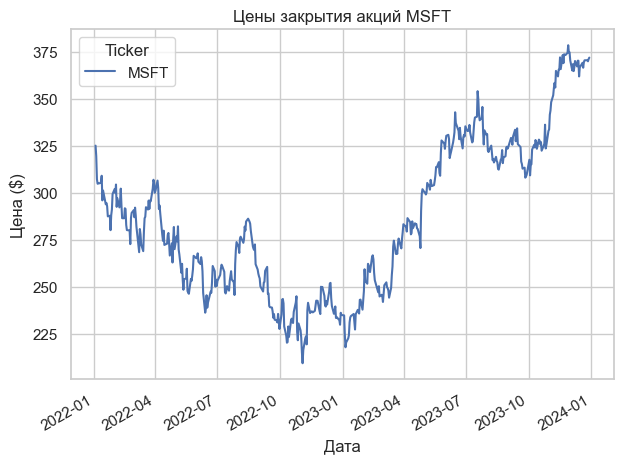

In [22]:
plt.figure(figsize=(12, 6))
ts.plot(title=f"Цены закрытия акций {ticker}", lw=1.5)
plt.ylabel("Цена ($)")
plt.xlabel("Дата")
plt.tight_layout()
plt.savefig(f"{ticker}_original_series.png")
plt.show()

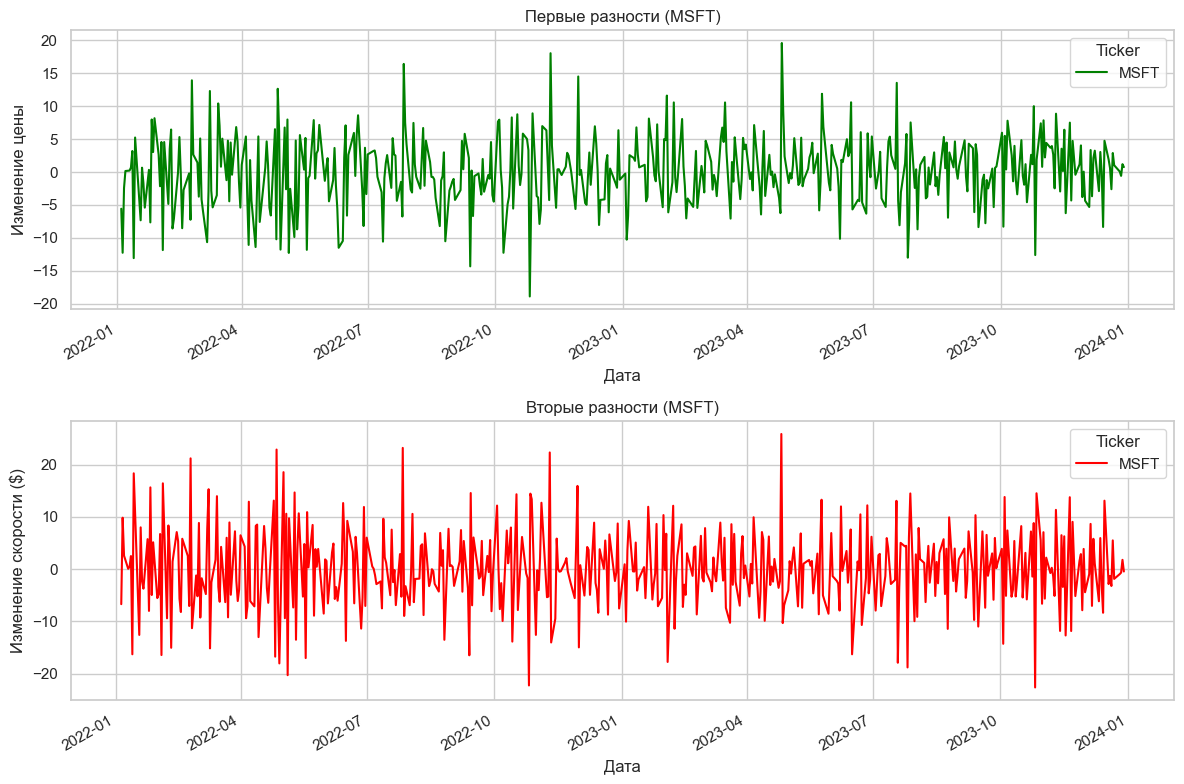

In [23]:
# Разностные ряды
ts_diff1 = ts.diff().dropna()
ts_diff1.name = "Первая разность"
ts_diff2 = ts_diff1.diff().dropna()
ts_diff2.name = "Вторая разность"

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
ts_diff1.plot(ax=axes[0], title=f"Первые разности ({ticker})", color='green')
axes[0].set_ylabel("Изменение цены")
axes[0].set_xlabel("Дата")
ts_diff2.plot(ax=axes[1], title=f"Вторые разности ({ticker})", color='red')
axes[1].set_ylabel("Изменение скорости ($)")
axes[1].set_xlabel("Дата")
plt.tight_layout()
plt.savefig(f"{ticker}_differencing.png")
plt.show()

# Анализ АКФ

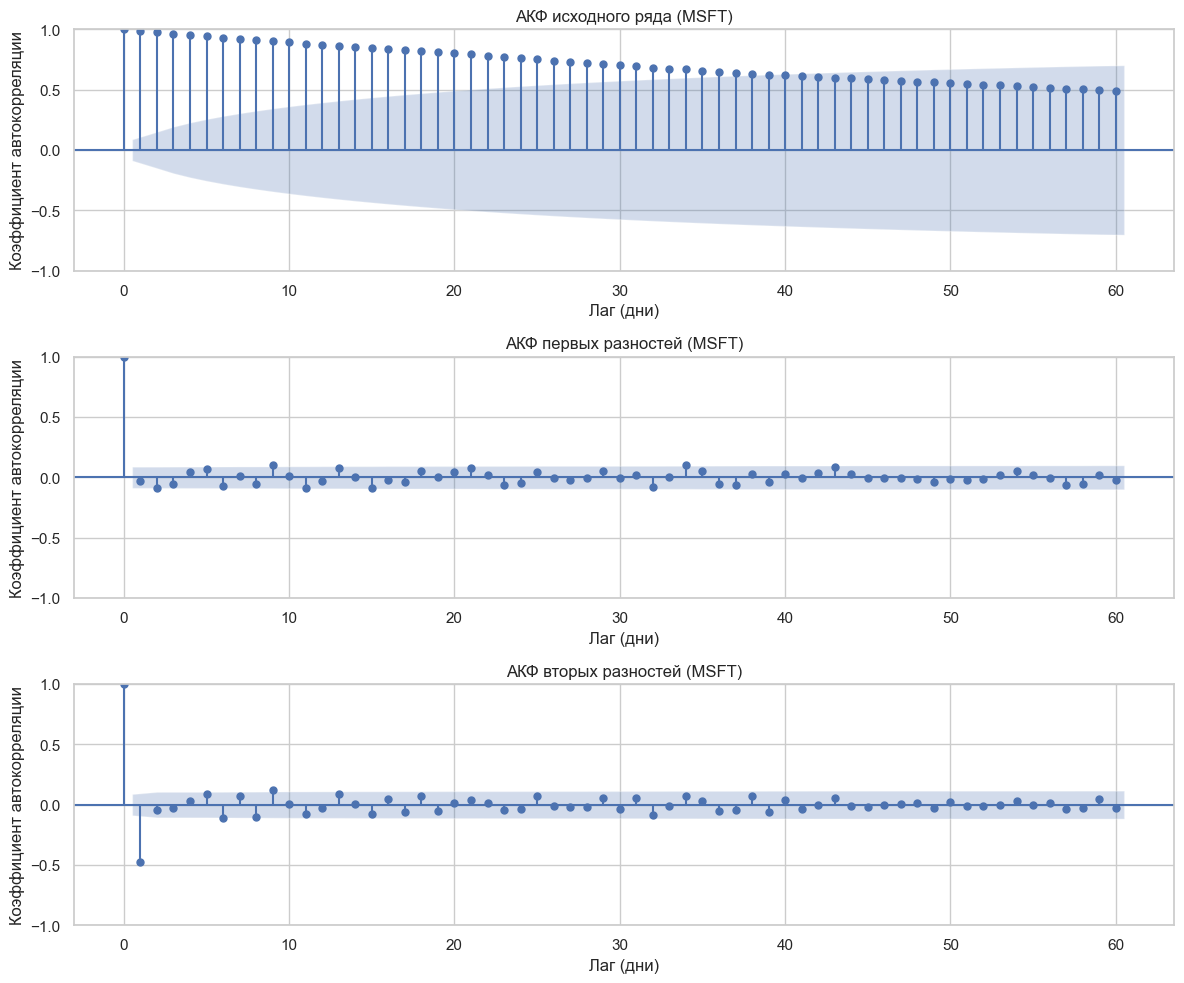

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

plot_acf(ts, ax=axes[0], lags=60, title=f"АКФ исходного ряда ({ticker})", alpha=0.05)
axes[0].set_ylabel("Коэффициент автокорреляции")
axes[0].set_xlabel("Лаг (дни)")

plot_acf(ts_diff1, ax=axes[1], lags=60, title=f"АКФ первых разностей ({ticker})", alpha=0.05)
axes[1].set_ylabel("Коэффициент автокорреляции")
axes[1].set_xlabel("Лаг (дни)")

plot_acf(ts_diff2, ax=axes[2], lags=60, title=f"АКФ вторых разностей ({ticker})", alpha=0.05)
axes[2].set_ylabel("Коэффициент автокорреляции")
axes[2].set_xlabel("Лаг (дни)")

plt.tight_layout()
plt.savefig(f"{ticker}_acf_analysis.png")
plt.show()

In [25]:
def detailed_acf_analysis(series, name, max_lags=15):
    from statsmodels.tsa.stattools import acf
    acf_values = acf(series, nlags=max_lags, fft=False)
    
    print(f"\nАнализ АКФ для {name}:")
    print(f"{'Лаг':<5} | {'Автокорреляция':<15} | Интерпретация")
    print("-"*45)
    
    for lag in range(0, max_lags+1):
        value = acf_values[lag]
        if lag == 0:
            interpretation = "Автокорреляция с самим собой"
        elif lag == 1:
            interpretation = "Сильная краткосрочная зависимость" if abs(value) > 0.5 else "Слабая краткосрочная зависимость"
        elif lag <= 5:
            interpretation = "Значимая среднесрочная зависимость" if abs(value) > 0.3 else "Слабая среднесрочная зависимость"
        else:
            interpretation = f"Возможная сезонность (лаг {lag})" if abs(value) > 0.2 else "Нет значимой зависимости"
                
        print(f"{lag:<5} | {value:+.4f}{'*' if abs(value) > 0.2 else '':<3} | {interpretation}")
    
    seasonal_lags = [5, 10, 15, 20]
    seasonal_detected = False
    for lag in seasonal_lags:
        if lag < len(acf_values) and abs(acf_values[lag]) > 0.2:
            print(f"Обнаружена возможная сезонность с периодом {lag} дней")
            seasonal_detected = True
    
    if not seasonal_detected:
        print("Сезонность не обнаружена")
    
    return acf_values


acf_orig = detailed_acf_analysis(ts, "исходного ряда")


acf_diff1 = detailed_acf_analysis(ts_diff1, "первых разностей")


acf_diff2 = detailed_acf_analysis(ts_diff2, "вторых разностей")


Анализ АКФ для исходного ряда:
Лаг   | Автокорреляция  | Интерпретация
---------------------------------------------
0     | +1.0000*   | Автокорреляция с самим собой
1     | +0.9865*   | Сильная краткосрочная зависимость
2     | +0.9738*   | Значимая среднесрочная зависимость
3     | +0.9633*   | Значимая среднесрочная зависимость
4     | +0.9537*   | Значимая среднесрочная зависимость
5     | +0.9435*   | Значимая среднесрочная зависимость
6     | +0.9322*   | Возможная сезонность (лаг 6)
7     | +0.9224*   | Возможная сезонность (лаг 7)
8     | +0.9119*   | Возможная сезонность (лаг 8)
9     | +0.9031*   | Возможная сезонность (лаг 9)
10    | +0.8924*   | Возможная сезонность (лаг 10)
11    | +0.8824*   | Возможная сезонность (лаг 11)
12    | +0.8731*   | Возможная сезонность (лаг 12)
13    | +0.8643*   | Возможная сезонность (лаг 13)
14    | +0.8548*   | Возможная сезонность (лаг 14)
15    | +0.8449*   | Возможная сезонность (лаг 15)
Обнаружена возможная сезонность с периодом 5 дн

# Тест Дики-Фуллера

In [26]:
def run_adfuller(series, name):
    result = adfuller(series)
    print(f"\nРезультаты теста Дики-Фуллера для {name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Критические значения:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    # Вывод о стационарности
    if result[1] < 0.05:
        print("Вывод: Ряд стационарен (отвергаем H0)")
    else:
        print("Вывод: Ряд нестационарен (не отвергаем H0)")
    return result[1]


print(f"Анализ стационарности для {ticker}")

p_original = run_adfuller(ts, "исходного ряда")
p_diff1 = run_adfuller(ts_diff1, "первых разностей")
p_diff2 = run_adfuller(ts_diff2, "вторых разностей")

Анализ стационарности для MSFT

Результаты теста Дики-Фуллера для исходного ряда:
ADF Statistic: -0.4503
p-value: 0.9014
Критические значения:
   1%: -3.4435
   5%: -2.8674
   10%: -2.5699
Вывод: Ряд нестационарен (не отвергаем H0)

Результаты теста Дики-Фуллера для первых разностей:
ADF Statistic: -17.6470
p-value: 0.0000
Критические значения:
   1%: -3.4435
   5%: -2.8674
   10%: -2.5699
Вывод: Ряд стационарен (отвергаем H0)

Результаты теста Дики-Фуллера для вторых разностей:
ADF Statistic: -9.3366
p-value: 0.0000
Критические значения:
   1%: -3.4440
   5%: -2.8676
   10%: -2.5700
Вывод: Ряд стационарен (отвергаем H0)


# Экспоненциальное сглаживание

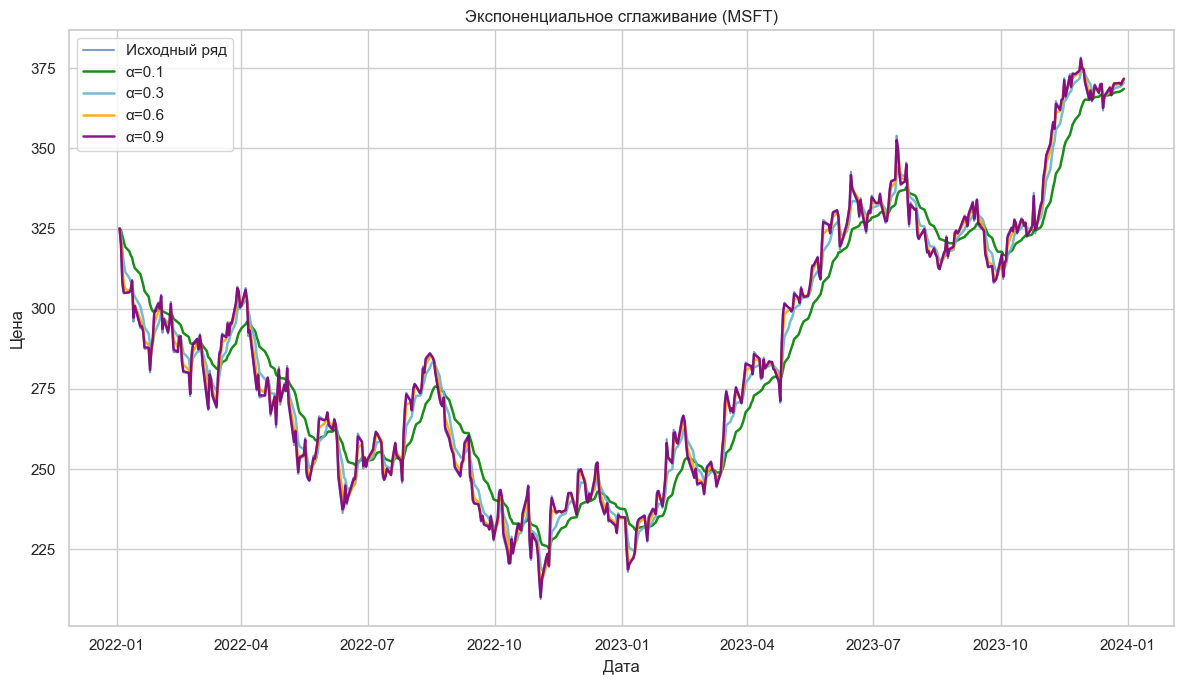

In [27]:
def exponential_smoothing(series, alpha):
    first_value = float(series.iloc[0])
    result = [first_value]
    for t in range(1, len(series)):
        current_value = float(series.iloc[t])
        result.append(alpha * current_value + (1 - alpha) * result[t-1])
    return pd.Series(result, index=series.index, name=f"α={alpha}")

alphas = [0.1, 0.3, 0.6, 0.9]
smoothed_series = [exponential_smoothing(ts, alpha) for alpha in alphas]

plt.figure(figsize=(12, 7))
plt.plot(ts.index, ts.values, label="Исходный ряд", lw=1.5, alpha=0.7)

colors = ['green', 'c', 'orange', 'purple']
for smoothed, alpha, color in zip(smoothed_series, alphas, colors):
    plt.plot(smoothed.index, smoothed.values, alpha=0.9, lw=1.8, color=color, label=f"α={alpha}")

plt.title(f"Экспоненциальное сглаживание ({ticker})")
plt.legend()
plt.ylabel("Цена")
plt.xlabel("Дата")
plt.tight_layout()
plt.savefig(f"{ticker}_smoothing.png")
plt.show()